<a href="https://colab.research.google.com/github/nepridumalnik/Jupyter-Notebooks/blob/master/speech_recognizer/SpeechRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Интересные ссылки:
- [Конкурс](https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge);
- [Исследование данных](https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration);
- [Загрузка файлов](https://www.tensorflow.org/io/api_docs/python/tfio/audio/decode_wav);
- [Keras с ансамблем](https://www.kaggle.com/code/araspirbadian/voice-command-detection).


# Подготовка данных
## Загрузка архива с сэмплами

In [ ]:
import requests
from tqdm import tqdm
import os

URL: str = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
OUT_FILE: str = "./speech_commands_v0.01.tar.gz"

def download_file(url: str, out_file: str) -> None:
  CHUNK_SIZE: int = 2 * 1024 * 1024

  if os.path.exists(out_file):
    print(f"File \"{out_file}\" exists")
    return

  with requests.get(url, stream=True) as request, open(out_file, "wb") as f:
    length = int(request.headers.get("content-length", 0))
    steps = length // CHUNK_SIZE + (1 if length % CHUNK_SIZE else 0)

    for chunk in tqdm(request.iter_content(chunk_size=CHUNK_SIZE),
                      total=steps, unit="chunk"):
      if chunk:
        f.write(chunk)


download_file(URL, OUT_FILE)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [02:26<00:00,  4.87chunk/s]


## Распаковка

In [ ]:
import tarfile

ARCHIVE_DIR: str = "inputs"

def extract_file(file_path: str, extract_path: str) -> None:
  if os.path.exists(extract_path) and os.listdir(extract_path):
    print(f"Directory \"{extract_path}\" exists")
    return

  with tarfile.open(file_path, "r:gz") as tar:
    members = tar.getmembers()
    with tqdm(total=len(members), unit="file") as pbar:
      for member in members:
        tar.extract(member, path=extract_path)
        pbar.update(1)

extract_file(OUT_FILE, ARCHIVE_DIR)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64764/64764 [05:25<00:00, 199.11file/s]


## Получаем список лейблов

In [ ]:
NOISE_LABEL: str = "_background_noise_"

LABELS = set([ name for name in os.listdir(ARCHIVE_DIR)
              if os.path.isdir(os.path.join(ARCHIVE_DIR, name)) ])
LABELS.remove(NOISE_LABEL)

LABELS


{'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero'}

# Изучение данных
## Загрузить WAV файл

In [ ]:
from tensorflow import io as io
from tensorflow import audio
from tensorflow import signal
import numpy as np

test_label = next(iter(LABELS))

file_path = str()

for e in os.listdir(os.path.join(ARCHIVE_DIR, test_label)):
  file_path = os.path.join(ARCHIVE_DIR, test_label, e)
  break

file_data = io.read_file(file_path)
samples, sample_rate = audio.decode_wav(file_data)

spectrogram = signal.stft(tf.squeeze(samples, axis=-1),
                          frame_length=256,
                          frame_step=128)
sample_rate


<tf.Tensor: shape=(), dtype=int32, numpy=16000>

## Демонстрация аудио данных

Показана волона и спектрограмма

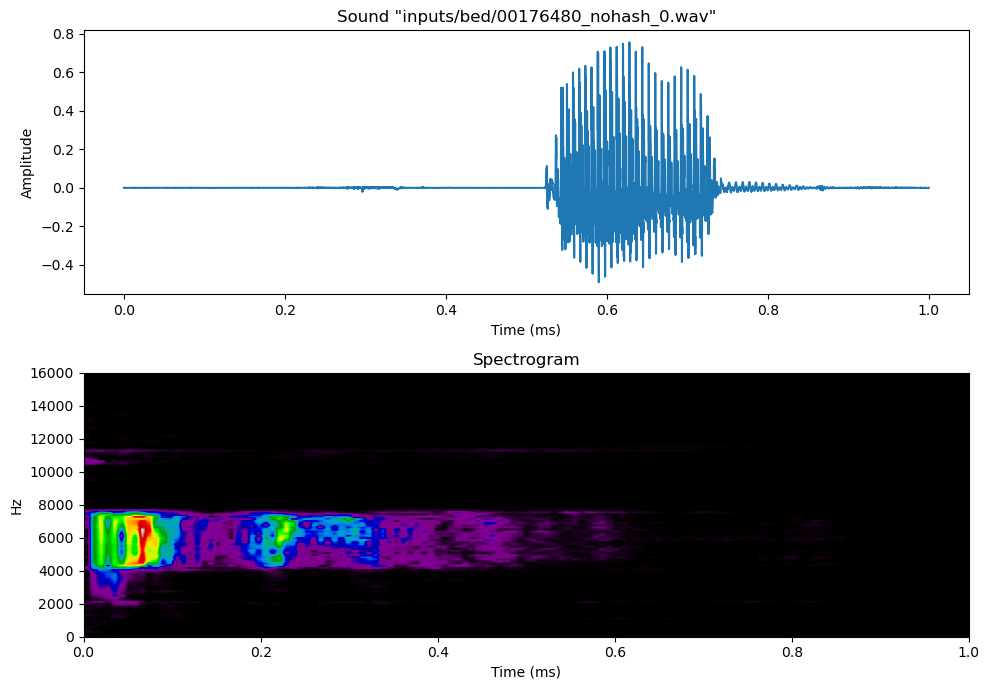

In [ ]:
import matplotlib.pyplot as plt

plot = plt.figure(figsize=(10, 7))
subplot_1 = plot.add_subplot(211)
subplot_1.plot(
    np.linspace(0, sample_rate/len(samples), sample_rate), samples
)

subplot_1.set_title(f"Sound \"{file_path}\"")
subplot_1.set_ylabel("Amplitude")
subplot_1.set_xlabel("Time (ms)")

subplot_2 = plot.add_subplot(212)
subplot_2.imshow(
    np.log1p(np.abs(spectrogram.numpy())),
    aspect="auto",
    cmap="nipy_spectral",
    extent=[0, 1, 0, int(test_audio.shape[0])]
)

subplot_2.set_title("Spectrogram")
subplot_2.set_ylabel("Hz")
subplot_2.set_xlabel('Time (ms)')

plot.tight_layout()
